# Fracture Classification with Datamint and FracAtlas Dataset

Train a binary classification model to detect fractures in musculoskeletal radiographs using the FracAtlas dataset.

In [ ]:
from datamint import Api

PROJECT_NAME = "FracAtlas"

api = Api()

## Setup: Create Project and Upload Dataset

In [ ]:
from datamint.mlflow import set_project

proj = api.projects.get_by_name(PROJECT_NAME)
if not proj:
    print(f"Creating project '{PROJECT_NAME}'")
    proj = api.projects.create(name=PROJECT_NAME,
                               description="Project to train a segmentation model on FracAtlas dataset")
    
set_project(PROJECT_NAME)

### Download FracAtlas Dataset

Dataset source: [Figshare](https://doi.org/10.6084/m9.figshare.22363012)

**Citation:** Abedeen, I., et al. (2023). FracAtlas: A Dataset for Fracture Classification, Localization and Segmentation of Musculoskeletal Radiographs. Scientific Data, 10(1). doi:10.1038/s41597-023-02432-4

In [ ]:
import requests
import zipfile
import os

# Retrieve and download FracAtlas dataset from Figshare
# It might take a while depending on your internet connection. ~50 seconds on a 100Mbps connection
r = requests.get('https://api.figshare.com/v2/articles/22363012')
if r.status_code == 200:
    file_metadata = r.json()['files'][0]
    file_name = file_metadata['name']
    print(f'Downloading {file_name}...')
    
    # Download and extract
    r = requests.get(file_metadata['download_url'], allow_redirects=True)
    with open(file_name, 'wb') as f:
        f.write(r.content)
    
    print(f'Unzipping {file_name}...')
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall(os.path.splitext(file_name)[0])
else:
    print('Error:', r.text)

The dataset is structured as follows:

```bash
FracAtlas/
├── images/
│   ├── Fractured/
│   │   ├── IMG0000110.jpg
│   │   └── ...
│   └── Non_fractured/
│       ├── IMG0002341.jpg
│       └── ...
├── Utilities/
└── ...
```

We are going to use the `images` folder for our binary classification task.

In [ ]:
from pathlib import Path
import os

# get all non-fractured images
non_fractured_root_path = Path('FracAtlas/FracAtlas/images/Non_fractured/')
fractured_root_path = Path('FracAtlas/FracAtlas/images/Fractured/')
non_fractured_images_paths = [str(non_fractured_root_path / img) for img in os.listdir(non_fractured_root_path)]
fractured_images_paths = [str(fractured_root_path / img) for img in os.listdir(fractured_root_path)]

print(f'Found {len(non_fractured_images_paths)} non-fractured images')
print(f'Found {len(fractured_images_paths)} fractured images')

In [ ]:
# Upload non-fractured images with tags for helping us later in the annotation creation
new_resources_list = api.resources.upload_resources(non_fractured_images_paths,
                                                    tags=['fracatlas', 'non-fractured'],
                                                    publish_to=proj,  # associate the resources to the project
                                                    progress_bar=True)

In [ ]:
# Upload fractured images with tags for helping us later in the annotation creation
new_resources_list = api.resources.upload_resources(fractured_images_paths,
                                                    tags=['fracatlas', 'fractured'],
                                                    publish_to=proj,  # associate the resources to the project
                                                    progress_bar=True)

In [ ]:
from tqdm.auto import tqdm

# Annotate non-fractured images with 'has_fracture: no'
nonfrac_resources_list = api.resources.get_list(project_name=PROJECT_NAME,
                                                tags=['non-fractured'])
for res in tqdm(nonfrac_resources_list):
    api.annotations.create_image_classification(resource=res,
                                                identifier='has_fracture',
                                                value='no')

In [ ]:
# Annotate fractured images with 'has_fracture: yes'
frac_resources_list = api.resources.get_list(project_name=PROJECT_NAME,
                                             tags=['fractured'])
for res in tqdm(frac_resources_list):
    api.annotations.create_image_classification(resource=res,
                                                identifier='has_fracture',
                                                value='yes')

In [ ]:
# Verify annotation was created successfully
api.annotations.get_list(resource=frac_resources_list[0])[0].asdict()

### Create Train/Val/Test Splits

Split the dataset into 80% training, 10% validation, and 10% testing with class balance maintained across splits.

In [ ]:
# splitting
import random

all_resources = list(api.resources.get_list(project_name=PROJECT_NAME,
                                            tags=['fracatlas']))
# sort filename to ensure reproducibility
all_resources.sort(key=lambda r: r.filename)
random.seed(123)
random.shuffle(all_resources)
n_total = len(all_resources)
n_train = int(0.8 * n_total)
n_val = int(0.1 * n_total)
n_test = n_total - n_train - n_val
train_resources = all_resources[:n_train]
val_resources = all_resources[n_train:n_train + n_val]
test_resources = all_resources[n_train + n_val:]

print(f'Total resources: {n_total}')
print(f'Training resources: {len(train_resources)}')
print(f'Validation resources: {len(val_resources)}')
print(f'Test resources: {len(test_resources)}')

Tag resources to identify their split assignment.

In [ ]:
for res in train_resources:
    api.resources.add_tags(res, ['split:train'])
for res in val_resources:
    api.resources.add_tags(res, ['split:val'])
for res in test_resources:
    api.resources.add_tags(res, ['split:test'])

In [ ]:
# Verify split distribution and class balance
train_resources = api.resources.get_list(tags=['split:train'])
test_resources = api.resources.get_list(tags=['split:test'])
val_resources = api.resources.get_list(tags=['split:val'])
total_train = len(train_resources)
total_val = len(val_resources)
total_test = len(test_resources)
train_fractured_ratio = len([r for r in train_resources if 'fractured' in r.tags]) / total_train
val_fractured_ratio = len([r for r in val_resources if 'fractured' in r.tags]) / total_val
test_fractured_ratio = len([r for r in test_resources if 'fractured' in r.tags]) / total_test

print('Training set: total={}, fractured ratio={:.0%}'.format(total_train, train_fractured_ratio))
print('Validation set: total={}, fractured ratio={:.0%}'.format(total_val, val_fractured_ratio))
print('Test set: total={}, fractured ratio={:.0%}'.format(total_test, test_fractured_ratio))



## Dataset Preparation

Define data transforms and create a PyTorch Dataset class for loading images and annotations from Datamint.

In [ ]:
import albumentations as A

train_transforms = A.Compose([
    A.Resize(480, 480),
    A.RandomBrightnessContrast(p=0.5), # data augmentation
    A.HorizontalFlip(p=0.5), # data augmentation
    A.ToRGB(), # ensure 3 channels
    A.ToTensorV2(),
])

test_transforms = A.Compose([
    A.Resize(480, 480),
    A.ToRGB(), # ensure 3 channels
    A.ToTensorV2(),
])

In [ ]:
import torch.utils.data
import numpy as np


class FracAtlasDataset(torch.utils.data.Dataset):
    """Load FracAtlas images and annotations from Datamint for classification.
    
    Args:
        project_name (str): Datamint project name
        split (str | None): Filter by split tag ('train', 'val', 'test')
        transforms: Albumentations transforms to apply
        return_annotations (bool): Include class labels in output
    """
    def __init__(self,
                 project_name: str,
                 split: str | None = None,
                 transforms=None,
                 return_annotations=True,
                 ):
        """
        Args:
            project_name (str): Name of the Datamint project containing the FracAtlas dataset.
            split (str | None): If provided, filters resources by the specified split tag ('train', 'val', 'test').
            transforms: Albumentations transforms to apply to the images. Optional.
            return_annotations (bool): If True, returns class labels along with images.
        """
        self.api = Api()
        self.project = self.api.projects.get_by_name(project_name)
        self.transforms = transforms
        self.return_annotations = return_annotations

        if not self.project:
            raise ValueError(f"Project '{project_name}' not found.")

        self.resources = self.project.fetch_resources()
        if split:
            self.resources = [res for res in self.resources if f'split:{split}' in res.tags]
        if return_annotations:
            self.category_annotations = []
            for resource in self.resources:
                annotations = resource.fetch_annotations(annotation_type='category')
                self.category_annotations.append(annotations)

    def __len__(self):
        return len(self.resources)

    def __getitem__(self, idx: int):
        resource = self.resources[idx]

        # Download the image data
        image_data = resource.fetch_file_data(auto_convert=True,
                                              use_cache=True)  # use_cache=True to avoid re-downloading. By default stored at "~/.datamint/"
        # image_data is auto converted to a PIL Image (since it is a png image file).
        image_data = image_data.convert('L')  # convert to grayscale
        # convert to numpy array float32
        image_data = np.array(image_data, dtype=np.float32)
        image_data /= 255.0  # normalize to [0, 1]
        # apply transforms if any
        if self.transforms:
            image_data = self.transforms(image=image_data)['image']
            # image_data.shape: torch.Size([3, 480, 480])

        if not self.return_annotations:
            return image_data
        
        # Extract 'has_fracture' annotation
        annotations = self.category_annotations[idx]
        for ann in annotations:
            if ann.identifier == 'has_fracture':
                has_fracture = int(ann.value.lower() == 'yes')
                return image_data, has_fracture
        raise ValueError(f"Annotation 'has_fracture' not found for '{resource.filename}'")

In [ ]:
# dataloaders
from torch.utils.data import DataLoader

train_dataset = FracAtlasDataset(project_name=PROJECT_NAME, split='train', transforms=train_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)

val_dataset = FracAtlasDataset(project_name=PROJECT_NAME, split='val', transforms=test_transforms)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)

test_dataset = FracAtlasDataset(project_name=PROJECT_NAME, split='test', transforms=test_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

## Train the model

We define our model by extending `lightning.LightningModule` which extends PyTorch `nn.Module`, but handles the dirty work for us.
More details at https://lightning.ai/docs/pytorch/LTS/common/lightning_module.html

In [ ]:
from torchvision.models import resnet18
import torch
import lightning as L

class FracAtlasClassifier(L.LightningModule):
    def __init__(self):
        super().__init__()

        ## loading the backbone ResNet18 ##
        self.model = resnet18(weights='DEFAULT')

        # Binary classification (fractured vs non-fractured)
        # We change the final layer to output 2 classes
        self.model.fc = torch.nn.Linear(self.model.fc.in_features, 2)

        # Our loss function
        self.criterion = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def _run_step(self, batch):
        """Common step for training, validation, and testing."""
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._run_step(batch)
        self.log("train/loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._run_step(batch)
        self.log("val/loss", loss, on_step=False, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss = self._run_step(batch)
        self.log("test/loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer


model = FracAtlasClassifier()

In [ ]:
import torch
from datamint.mlflow.lightning.callbacks import MLFlowModelCheckpoint
from lightning.pytorch.loggers import MLFlowLogger

set_project(PROJECT_NAME) # Ensure the project is set

# This callback will do the following:
# - Save the best model based on validation loss.
# - Register the best model in our server automatically.
checkcb = MLFlowModelCheckpoint(
    monitor="val/loss",                  # Metric to monitor for best model
    mode="min",                          # Save model when monitored metric decreases
    save_top_k=1,                        # Keep only the best model
    filename="best",                     # Checkpoint filename
    save_weights_only=True,              # Save only model weights (not optimizer state)
    register_model_name=PROJECT_NAME,    # Name for model registry
    register_model_on='test',            # Register model after testing
    # code_paths=['my_custom_model.py'],   # Include source code with model
    log_model_at_end_only=True,          # Log to MLflow only at the end (faster)
)

# Start Training
# ==============

print("🚀 Starting training...")
mlflow_logger = MLFlowLogger(experiment_name=PROJECT_NAME)
trainer = L.Trainer(
    max_epochs=10,                       # Number of training epochs
    logger=mlflow_logger,                # MLflow integration
    enable_model_summary=True,           # Show model architecture summary
    enable_progress_bar=True,            # Show training progress
    callbacks=[checkcb],                 # Include our checkpoint callback
    num_sanity_val_steps=0,              # Skip validation sanity check
)
trainer.fit(model,
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader)

While running, 
- you can check saved model locally with name "best.ckpt";
- And you can check experiment details on the Datamint platform:

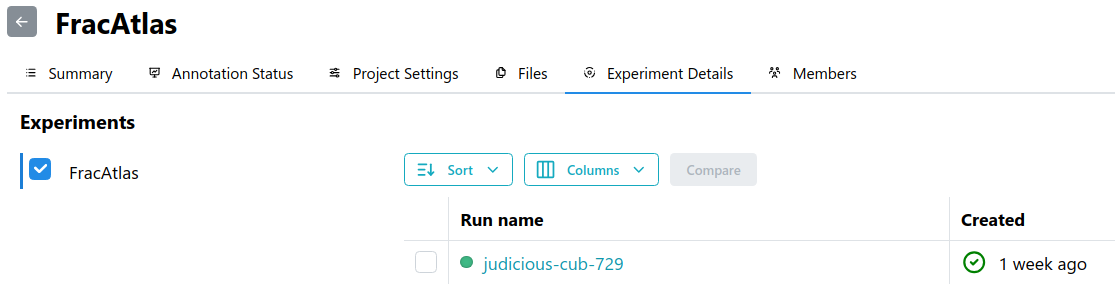

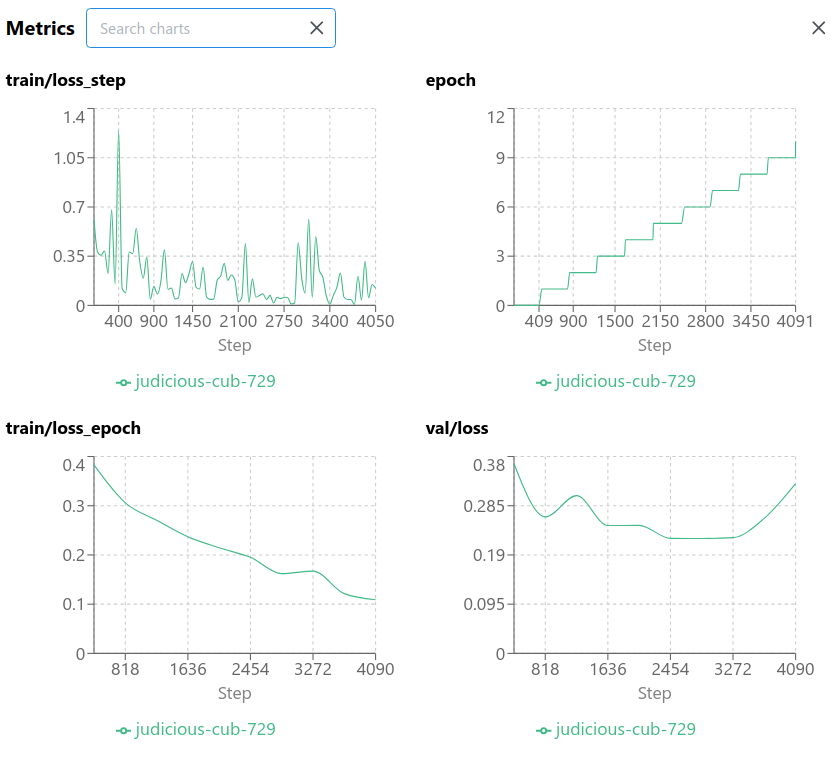

In [ ]:
proj.show() # Display project details in Datamint platform

In [ ]:
# Start Testing. Important to register the best model
trainer.test(dataloaders=test_dataloader)

# Predicting

In [ ]:
# Create a new trainer for prediction (no training setup needed)
import mlflow
import lightning as L
from torch.utils.data import DataLoader

pred_trainer = L.Trainer(
    enable_model_summary=True,
    enable_progress_bar=True,
)

registered_model = mlflow.pytorch.load_model(f'models:/{PROJECT_NAME}/latest')

# Set up data module for prediction (same as before, but without annotations)
test_dataset = FracAtlasDataset(project_name=PROJECT_NAME, split='test',
                                transforms=test_transforms, return_annotations=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

# Option 1: Use model already in memory
preds = pred_trainer.predict(
    registered_model,
    # ckpt_path=checkcb.best_model_path,  # Uncomment to load from checkpoint
    dataloaders=test_dataloader
)

# Option 2: Load from MLflow Model Registry (commented out)
# registered_model = mlflow.pytorch.load_model(f'models:/{PROJECT_NAME}/latest')
# preds = pred_trainer.predict(registered_model, datamodule=pred_dm)


print(f"✅ Predictions completed!")
print(f"First batch shape: {preds[0].shape}")
print(f'First batch, class with max probability: {preds[0].argmax(dim=1)}')